<a href="https://colab.research.google.com/github/peterhaasme/nc_covid19_dashboard/blob/one_df/nc_covid19_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries



In [0]:
import pandas as pd
pd.set_option('display.max_rows', None)
from datetime import datetime, timedelta 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image
import requests

#Create dataframes

In [0]:
df = pd.read_json('https://covidtracking.com/api/v1/states/nc/daily.json') # Read in NC time series from Covid Tracking Project
df = df.fillna(0) # Replace NaN with 0
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d') # Convert date to datetime object
df['date_col'] = df['date'].dt.strftime('%b %d, %Y') # Create date column for plotly table
df = df.iloc[::-1].reset_index(drop=True) # Order DataFrame by chronological ascending
df_col_names = list(df.columns) # Create list of column names for plots

##Dashboard Table

In [3]:
metrics = ['COVID-like Illnesses (CLI)', 'Hospitalizations', 'New Cases', 'Percent Positive Tests', 'Testing Capacity']
indicator = ['Green', 'Red', 'Green', 'Red', 'Green']
cell_color = ['lightgrey', ['red' if i == 'Red' else 'green' for i in indicator]]
table_trace = go.Figure(data = [go.Table(
    columnorder = [1,2],
    columnwidth = [200, 80],
    header = dict(
        values = ['<b>Metric</b>', '<b>Status</b>'],
        fill_color = 'grey'
        ),
    cells = dict(
        values = [metrics, indicator],
        fill_color = cell_color
        )
)])
table_trace

##Current Totals

###Subplots

In [57]:
# Construct totals table + graphs
totals_table = go.Table(
    header=dict(values=['Date', 'Positive Cases', 'Hospitalized', 'Deaths'],
                align='center'),
    cells=dict(values=[df['date_col'][::-1], df['positive'][::-1], df['hospitalizedCurrently'][::-1], df['death'][::-1]],
               align='center')
    )

positive_scatter = go.Scatter(
        x=df['date'],
        y=df['positive'],
        mode="lines+markers",
        name="positive cases"
    )

hospitalized_bar = go.Bar(
        x=df['date'],
        y=df['hospitalizedCurrently'],
        name="hospitalized"
    )

death_scatter = go.Scatter(
        x=df['date'],
        y=df['death'],
        mode="lines+markers",
        name="deaths"
    )

# Initialize figure with subplots
snapshot_fig = make_subplots(
    rows=4, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.06,
    subplot_titles = ('Daily Totals', 'Total Positive Cases', 'Hospitalized', 'Total Deaths'),
    specs=[[{"type": "table"}],
           [{"type": "scatter"}],
           [{"type": "bar"}],
           [{"type": "scatter"}]]
)

# Add traces
snapshot_fig.append_trace(totals_table, row = 1, col = 1)
snapshot_fig.append_trace(positive_scatter, row = 2, col = 1)
snapshot_fig.append_trace(hospitalized_bar, row = 3, col = 1)
snapshot_fig.append_trace(death_scatter, row = 4, col = 1)

# Update title and height
snapshot_fig.update_layout(
    title_text="NC COVID-19 Snapshot", 
    height=800,
    showlegend = False
    )

snapshot_fig

## Covid-Like Illness (CLI)
Q: Is North Carolina seeing a continued downward trajectory or sustained leveling of COVID-Like Illnesses (CLI) in its surveillance systems?

A: Yes

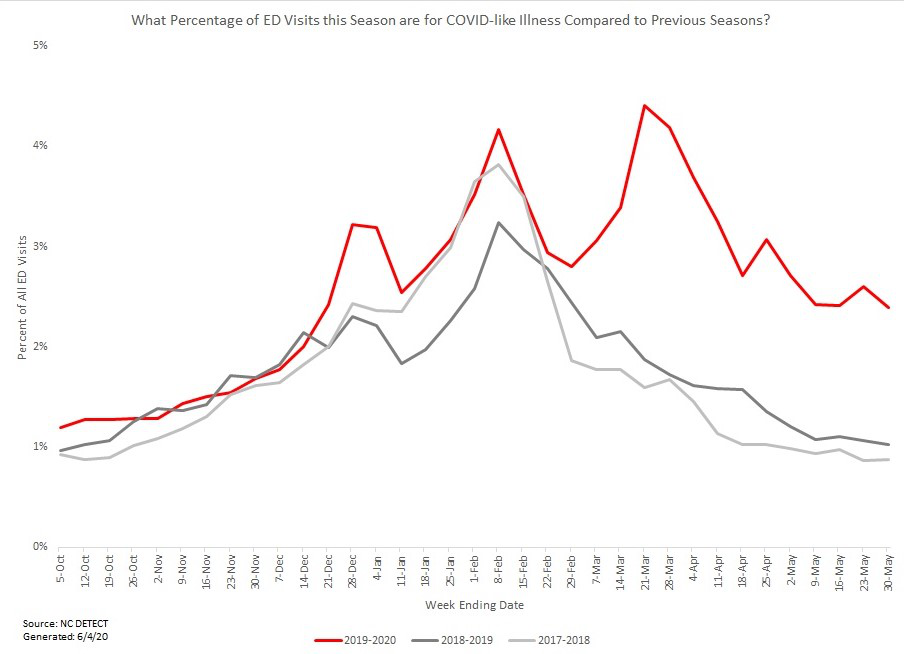

In [6]:
im = Image.open(requests.get('https://files.nc.gov/ncdhhs/images/covid19/dashboards/M_EDvisits_COVID.jpg', stream=True).raw)
im

##Hospitalizations
Is North Carolina seeing a 14 day downward trajectory or sustained leveling in the number of people currently hospitalized?

In [0]:
# Create DataFrame of currently hospitalized
current_hospital = df[['date', 'hospitalizedCurrently']].copy() 
# Drop NaN values
current_hospital.dropna(inplace=True)
# Convert date to datetime object
current_hospital['date'] = pd.to_datetime(current_hospital['date'], format='%Y%m%d')
# Order DataFrame by chronological ascending
current_hospital = current_hospital.iloc[::-1].reset_index(drop=True)
# Add 14d moving average column
current_hospital['avg'] = current_hospital['hospitalizedCurrently'].rolling(14).mean().round()

In [8]:
# Get date of max cases. Subtract today's date. Are they less than or equal to 14?
hospital_max_date = current_hospital[current_hospital['hospitalizedCurrently']==current_hospital['hospitalizedCurrently'].max()].iloc[0,0]
hospital_max_date_format = hospital_max_date.strftime('%b %d, %Y')
today = datetime.today()
diff = today - hospital_max_date
if diff.days <= 14:
  print(f'A: No. There was a new peak on {hospital_max_date_format}.')
else:
  print(f'A: Yes. The last peak was {hospital_max_date_format}.')

A: No. There was a new peak on Jun 09, 2020.


In [9]:
# Create figure
hospitalized_bar = go.Figure()

# Add bar chart and 14d moving average 
hospitalized_bar.add_trace(
    go.Bar(
        x=current_hospital['date'],
        y=current_hospital['hospitalizedCurrently'],
        name="Hospitalized"
    )
)
hospitalized_bar.add_trace(
    go.Scatter(
        x=current_hospital['date'],
        y=current_hospital['avg'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
hospitalized_bar.update_layout(
    title_text="Currently Hospitalized",
    yaxis_title="# of Patients",
    height=400
    )

hospitalized_bar

##New cases
Is North Carolina seeing a downward trajectory over 14 days, or sustained leveling in new cases?

In [0]:
# Create DataFrame of daily new lab-confirmed cases
new_cases = df[['date', 'positiveIncrease']].copy() 
# Drop NaN values
new_cases.dropna(inplace=True)
# Convert date to datetime object
new_cases['date'] = pd.to_datetime(new_cases['date'], format='%Y%m%d')
# Order DataFrame by chronological ascending
new_cases = new_cases.iloc[::-1].reset_index(drop=True)
# Add 14d moving average column
new_cases['avg'] = new_cases['positiveIncrease'].rolling(14).mean().round()

In [11]:
# Get date of max cases. Subtract today's date. Are they less than or equal to 14?
new_cases_max_date = new_cases[new_cases['positiveIncrease']==new_cases['positiveIncrease'].max()].iloc[0,0]
new_cases_date_format = new_cases_max_date.strftime('%b %d, %Y')
today = datetime.today()
diff = today - new_cases_max_date
if diff.days <= 14:
  print(f'A: No. There was a new peak on {new_cases_date_format}.')
else:
  print(f'A: Yes. The last peak was {new_cases_date_format}.')

A: No. There was a new peak on Jun 06, 2020.


In [12]:
# Create figure
new_cases_bar = go.Figure()

# Add bar chart and 14d moving average 
new_cases_bar.add_trace(
    go.Bar(
        x=new_cases['date'],
        y=new_cases['positiveIncrease'],
        name="New Cases"
    )
)
new_cases_bar.add_trace(
    go.Scatter(
        x=new_cases['date'],
        y=new_cases['avg'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
new_cases_bar.update_layout(
    title_text="New Covid-19 Cases",
    yaxis_title="# of Positive Tests",
    height=400
    )

new_cases_bar

## Percent Positive Tests
Is North Carolina seeing a 14 day downward trajectory or sustained leveling of positive tests as a percentage of total tests?


In [0]:
# Create DataFrame of positive and total new tests
percent_positive_df = df[['date', 'positiveIncrease', 'totalTestResultsIncrease']].copy()
# Drop NaN values
percent_positive_df.dropna(inplace=True)
# Convert date to datetime object
percent_positive_df['date'] = pd.to_datetime(percent_positive_df['date'], format='%Y%m%d')
# Order DataFrame by chronological ascending
percent_positive_df = percent_positive_df.iloc[::-1].reset_index(drop=True)
# Drop records before April 21, 2020
percent_positive_df = percent_positive_df[percent_positive_df['date'] >= '2020-04-21']
# Calculate positive test percentage
percent_positive_df['percent_pos'] = (percent_positive_df['positiveIncrease'] / percent_positive_df['totalTestResultsIncrease'] * 100).round(1)
# Add 14d moving average column
percent_positive_df['avg_percent_pos'] = percent_positive_df['percent_pos'].rolling(14).mean().round(1)

In [14]:
# Get date of max percent positive. Subtract today's date. Are they less than or equal to 14?
percent_positive_max_date = percent_positive_df[percent_positive_df['percent_pos']==percent_positive_df['percent_pos'].max()].iloc[0,0]
percent_positive_date_format = percent_positive_max_date.strftime('%b %d, %Y')
today = datetime.today()
diff = today - percent_positive_max_date
if diff.days <= 14:
  print(f'A: No. There was a new peak on {percent_positive_date_format}.')
else:
  print(f'A: Yes. The last peak was {percent_positive_date_format}.')

A: Yes. The last peak was Apr 27, 2020.


In [15]:
# Create figure
percent_positive_df_bar = go.Figure()

# Add bar chart and 14d moving average 
percent_positive_df_bar.add_trace(
    go.Bar(
        x=percent_positive_df['date'],
        y=percent_positive_df['percent_pos'],
        name="Percent Positive Tests"
    )
)
percent_positive_df_bar.add_trace(
    go.Scatter(
        x=percent_positive_df['date'],
        y=percent_positive_df['avg_percent_pos'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
percent_positive_df_bar.update_layout(
    title_text="Positive Tests as a Percentage of Total",
    yaxis_title="% Positive Tests",
    height=400
    )

percent_positive_df_bar

## Test Capacity
Does NC have the capacity to test an average of 5000 - 7000 people daily?

In [0]:
# Add column for 14d total test moving average
percent_positive_df['avg_daily_tests'] = percent_positive_df['totalTestResultsIncrease'].rolling(14).mean().round()

In [17]:
percent_positive_df.tail()

,date,positiveIncrease,totalTestResultsIncrease,percent_pos,avg_percent_pos,avg_daily_tests
93,2020-06-05,1289,13845,9.3,6.8,12780.0
94,2020-06-06,1370,15203,9.0,7.2,11983.0
95,2020-06-07,921,13876,6.6,7.2,12469.0
96,2020-06-08,938,8887,10.6,7.3,12530.0
97,2020-06-09,676,15598,4.3,7.4,13099.0


In [18]:
capacity_14d = percent_positive_df['avg_daily_tests'][-14:]
capacity_14d_bool = (capacity_14d < 5000).any()
capacity_14d_mean = round(capacity_14d.mean())
if capacity_14d_bool == True:
  print(f'No. Over the last 14 days only an average of {capacity_14d_mean} people were tested each day.')
else:
  print(f'Yes. Over the last 14 days an average of {capacity_14d_mean} people were tested each day.')

Yes. Over the last 14 days an average of 12080 people were tested each day.


In [19]:
# Create figure
daily_tests_bar = go.Figure()

# Add bar chart and 14d moving average 
daily_tests_bar.add_trace(
    go.Bar(
        x=percent_positive_df['date'],
        y=percent_positive_df['totalTestResultsIncrease'],
        name="Tests Completed"
    )
)
daily_tests_bar.add_trace(
    go.Scatter(
        x=percent_positive_df['date'],
        y=percent_positive_df['avg_daily_tests'],
        mode="lines",
        name="14d Moving Average"
    )
)

# Update title and height
daily_tests_bar.update_layout(
    title_text="Daily Tests Reported",
    yaxis_title="# of Tests",
    height=400
    )

daily_tests_bar